<a href="https://colab.research.google.com/github/ravimashru/cassava-clf/blob/main/01-baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug  3 15:28:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -Uqq fastai

     |████████████████████████████████| 188 kB 8.5 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 


In [ ]:
!pip uninstall -q -y kaggle
!pip install -q --upgrade pip
!pip install -q kaggle==1.5.6

     |████████████████████████████████| 1.6 MB 8.4 MB/s 
     |████████████████████████████████| 58 kB 4.0 MB/s 


In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:08<00:00, 24.1MB/s]
100% 5.76G/5.76G [02:08<00:00, 48.0MB/s]


In [ ]:
!unzip -q cassava-leaf-disease-classification.zip

In [ ]:
!ls -l train_images | wc -l

21398


In [ ]:
import pandas as pd

df = pd.read_csv('wandb_cassava_train_val_split.csv')
df.head()

,image_id,label,is_val
0,1000015157.jpg,0,False
1,1000201771.jpg,3,False
2,100042118.jpg,1,False
3,1000723321.jpg,1,False
4,1000812911.jpg,3,False


In [ ]:
df.shape

(21397, 3)

In [ ]:
def splitter(df):
    train = df.index[~df['is_val']].tolist()
    valid = df.index[df['is_val']].tolist()
    return train, valid

In [ ]:
import fastai
from fastai.vision.all import *

print(fastai.__version__)

2.4.1


In [ ]:
path = Path()
(path/'train_images').ls()

(#21397) [Path('train_images/3878767715.jpg'),Path('train_images/3626179883.jpg'),Path('train_images/329537170.jpg'),Path('train_images/1297867546.jpg'),Path('train_images/976801924.jpg'),Path('train_images/2482838922.jpg'),Path('train_images/2614438244.jpg'),Path('train_images/1788333451.jpg'),Path('train_images/3324977995.jpg'),Path('train_images/410355412.jpg')...]

In [ ]:
path = Path()
def get_x(row):
    return path/'train_images'/row['image_id']

def get_y(row):
    return row['label']

get_x(df.iloc[0,:]), get_y(df.iloc[0,:])

(Path('train_images/1000015157.jpg'), 0)

In [ ]:
cassava = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    batch_tfms=Resize(224)
)

In [ ]:
dls = cassava.dataloaders(df, bs=16)

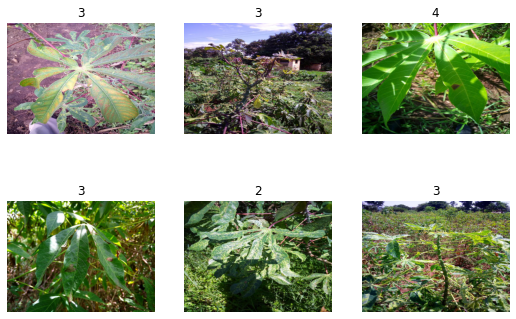

In [ ]:
dls.show_batch(nrows=2, ncols=3)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


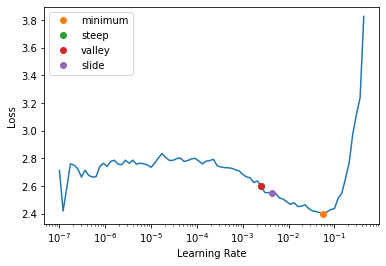

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide

(0.005754399299621582,
 0.002511886414140463,
 0.002511886414140463,
 0.004365158267319202)

In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.766982,0.653559,0.767002,11:36


epoch,train_loss,valid_loss,accuracy,time
0,0.526941,0.426200,0.855574,15:27
1,0.476611,0.436891,0.852068,15:26
2,0.519796,0.441614,0.844122,15:25
3,0.386335,0.424608,0.860014,15:25
4,0.235755,0.467870,0.862351,15:25
5,0.153414,0.511718,0.868427,15:26
6,0.079559,0.637984,0.869362,15:27
7,0.030866,0.620940,0.878710,15:26
8,0.021119,0.647510,0.878009,15:26
9,0.010215,0.642191,0.879645,15:26


In [ ]:
learn.export('model-ft-10.pkl')